# Ressources

In [252]:
import pandas as pd
import ast
import missingno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, classification_report


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import cluster, metrics
from sklearn import manifold, decomposition

import tensorflow as tf
import keras
from keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import metrics as kmetrics
from keras.layers import *
from keras.models import Model

import tensorflow_hub as hub

# Bert
import os
import transformers
from transformers import *

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

pd.options.mode.chained_assignment = None  # default='warn'


# Fonctions
## Graphiques

In [253]:
def subplots_2(data, var1, var2, height=1500):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(var1, var2),
                        specs=[[{"type": "domain"}, {"type": "domain"}]])

    fig.add_trace(go.Pie(labels=data[var1]), row=1, col=1)
    fig.add_trace(go.Pie(labels=data[var2]), row=1, col=2)

    fig.update_layout(height=height, showlegend=False)

    fig.update_traces(hoverinfo='label+percent+value',
                      textinfo='label+percent', textfont_size=12)

    fig.show()


## Fonctions textes

### Mots

In [254]:
# https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4470548-recuperez-et-explorez-le-corpus-de-textes

from nltk.corpus import stopwords


def tokenizer_fct(sentence):  # découpe l'expression en liste de mot
    """
    Découpe l'expression en liste de mot.

    La tokenization, qui désigne le découpage en mots des différents documents qui constituent votre corpus.

    Parameters
    ----------

    sentence : :class:`str` : Phrase à découper

    Return
    ----------
    Liste des mots découpés
    """

    sentence_clean = sentence.replace(
        '-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens


def compte_nombre_mots_colonne(df, colonne):
    """
    Compte le nombre de mots par ligne dans une colonne

    Parameters
    ----------

    df : :class:`dataframe` : Le dataframe

    colonne : :class:`colonne dataframe` : Colonne du dataframe à compter

    Return :
    ----------
    Le nombre de mots pour chaque ligne

    Exemples
    ----------
    data['length_bow'] = compte_nombre_mots_colonne(data, 'sentence_bow')
    """

    return df[colonne].apply(lambda x: len(word_tokenize(x)))


# Stop words # génère des mots "stop", comme les pronoms, des verbes d'état, des ponctuations... Des mots dont on ne veut pas
stop_w = list(set(stopwords.words('english'))) + \
    ['[', ']', ',', '.', ':', '?', '(', ')']


def stop_word_filter_fct(list_words):
    """
    La normalisation et la construction du dictionnaire qui permet de ne pas prendre en compte des détails importants au niveau local (ponctuation, majuscules, conjugaison, etc.)

    Parameters
    -----------

    list_words : :class:`list` : liste des mots où il faut exclure les parasites

    Exemples
    ----------
    stop_word = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

    Return
    ---------
    Liste des mots sans les stopwords
    """
    filtered_w = [
        w for w in list_words if not w in stop_w]  # affiche le mot de la list word s'il n'est pas dans la liste stop_w
    # affiche le mot de la liste filtered_w s'il fait plus de 2 lettres
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2


def lemma_fct(list_words):  # Lemmatizer (base d'un mot)  # découpe l'expression en liste de lettre
    """
    Le processus de « lemmatisation » consiste à représenter les mots (ou « lemmes » 😉) sous leur forme canonique. 
    Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.
    Dans le processus de lemmatisation, on transforme donc « suis » en « être»  et « attentifs » en « attentif ».

    Parameters
    ----------

    list_words : :class:`list` : liste des mots (de préférence après suppression des stopwords)

    Return
    ----------
    Liste des mots
    """
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


# lower les mots s'ils ne commencent pas par @ ou http
def lower_start_fct(list_words):
    """
    Lower les mots s'ils ne commencent pas par @ ou http

    Parameters
    ----------

    list_words : :class:`list` : liste des mots (de préférence après suppression des stopwords)


    Return
    ---------
    Liste des mots après lower()
    """
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
          #                                   and (not w.startswith("#"))
          and (not w.startswith("http"))]
    return lw


# cours associé : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words


def transform_word(desc_text, type: str):
    """ Fonctions de préparation du texte pour le bag of words (Countvectorize et Tf_idf, Word2Vec) 

    cours associé : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words

    La manière la plus simple de représenter un document, c'est ce qu'on a effectué dans le chapitre précédent où l'on a considéré tous les mots utilisés pour chaque artiste, sans distinction ni dépendance par vers, chanson, etc. 
    L'analogie est donc qu'on a considéré chaque artiste par la représentation brute d'un "sac" de tous les mots qu'il a utilisé, sans soucis de contexte (ordre, utilisation, etc).

    # Tf_idf :

    Depuis le départ, on a seulement utilisé les fréquences d'apparition des différents mots/n-grammes présents dans notre corpus. 
    Le problème est que si l'on veut vraiment représenter un document par les n-grammes qu'il contient, il faudrait le faire relativement à leur apparition dans les autres documents.

    En effet, si un mot apparait dans d'autres documents, il est donc moins représentatif du document qu'un mot qui n'apparait que uniquement dans ce document.

    Nous avons d'abord supprimé les mots les plus fréquents de manière générale dans le langage (les fameux stopwords).
    À présent, il ne faut pas considérer le poids d'un mot dans un document comme sa fréquence d'apparition uniquement, mais pondérer cette fréquence par un indicateur si ce mot est commun ou rare dans tous les documents.

    Pour résumer, le poids du n-gramme est le suivant :

    #### poids=fréquence du terme×indicateur similarité

    En l’occurence, la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique. 
    Il est appelé logiquement « inverse document frequency » (idf). 

    Parameters
    ----------

    desc_text :class:`Series`

    type :class:`Choix` : 
        - "classique" = stopword + lower -> Utilisable pour bag of word (countvectorize/tf_idf/word2vec)
        - "lem"  = stopword + lower puis lemmatizer pour bag of word
        - "dl" = lower pour deeplearning

    Return
    ----------

    Series sans stopword puis lower()

    Exemples
    ---------
    >>> data_T['sentence_bow'] = data_T0['text'].apply(lambda x : transform_word(x, "classique"))
    """
    sentence = tokenizer_fct(desc_text)  # découpage des mots

    if type in ["classique", "lem"]:
        sentence = stop_word_filter_fct(sentence)  # filtre des stopword

    sentence = lower_start_fct(sentence)  # lower des mots

    if type == "lem":
        sentence = lemma_fct(sentence)  # lemmatizer
    # on supprime la liste et on sépare les mots
    transf_desc_text = ' '.join(sentence)
    return transf_desc_text  # on return la phrase traitée


### Communes

In [255]:
import time


def preparation_variable_clustering(df, colonne):
    """Créer deux listes avec la variable discriminante qui servira à l'ARI.
    - La première contient les valeurs uniques pour le clustering
    - La seconde est une liste contenant les valeurs de la variable en format numérique.

    Parameters
    ----------

    df : :class:`DataFrame`
    
    colonne : :class:`Series` : Colonne du DataFrame qui est la variable discriminante

    Return
    ----------
    l_cat : Liste avec les valeurs uniques
    y_cat_num : Liste avec les valeurs str en int
    """
    l_cat = list(set(df[colonne])
                 )  # variable discriminante pour les graphiques
    # print("catégories : ", l_cat)

    # on transforme les catégories en valeurs numériques
    y_cat_num = [(l_cat.index(df.iloc[i][colonne])) for i in range(len(df))]
    
    l_num_cat = "categories : " + str([f" {categorie} : {l_cat.index(categorie)}" for categorie in l_cat])
    
    print(l_num_cat)
    return l_cat, y_cat_num

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def ARI_fct(features, l_cat, y_cat_num):
    """
    Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters

    Parameters
    ----------

    Features : :class:`transformé par un algorithme` : Features transformé par id-tf, cvc, bert, USE, Word2Vec.predict() ....

    l_cat : :class:`List` : Liste avec les valeurs uniques qui serviront de variables discriminantes

    y_cat_num : :class:`List` : Liste avec les valeurs transformées en nombre. Nécessaire pour comparaison Kmeans et réelles (ARI)


    """

    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI):
    """ 
    Visualisation du Tsne selon les vraies catégories et selon les clusters

    Parameters
    -----------

    X_tsne : :class:`Données T-SNE`

    l_cat : :class:`List` : Liste avec les valeurs uniques qui serviront de variables discriminantes

    y_cat_num : :class:`List`: Liste avec les valeurs transformées en numéro

    labels : :class:`List` : Liste avec les labels générés par Kmeans

    ARI : >>> ARI = np.round(metrics.adjusted_rand_score(y_cat_num, labels),4)

    """
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('K-Means Clustering')

    plt.show()

    cm = confusion_matrix(y_cat_num, labels)

    plt.imshow(cm, interpolation='none', cmap='Blues')
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, z, ha='center', va='center')
    plt.xlabel("kmeans label")
    plt.ylabel("truth label")
    plt.show()

    fig = px.pie(names=labels)
    fig.show()
    print("ARI : ", ARI)


### Word2Vec

In [256]:
import tensorflow as tf
import keras
from keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import metrics as kmetrics
from keras.layers import *
from keras.models import Model
import gensim


In [257]:
w2v_size = 300  # Dimensionality of the word vectors.
# Maximum distance between the current and predicted word within a sentence.
w2v_window = 5
w2v_min_count = 1  # Ignores all words with total frequency lower than this.
w2v_epochs = 100  # Number of iterations (epochs) over the corpus.
maxlen = 24


def preprocess_word2vec(data, colonne):
    """ 
    Prépare le word2vec


    Parameters
    ----------

    data :class:`DataFrame`

    colonne : :class:`Series`: Données lemmatizer


    Return
    ----------

    Liste avec une liste pour chaque ligne qui contient les mots de la ligne


    """

    sentences = data[colonne].to_list()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
    return sentences

# Création et entraînement du modèle Word2Vec


def modele_word2vec(sentences, w2v_min_count=1):
    """
    Création et entrainement du modèle Word2Vec

    Parameters
    ----------

    Sentences :class:`list` : Données lemmatizer
    w2v_min_count : :class:ìnt` : Ignores all words with total frequency lower than this.

    Return
    ----------

    w2v_model = Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/
    model_vectors = Dictionnaire avec les vecteurs de chaque mot.
    >>> model_vectors.key_to_index pour avoir la position de chaque mot
    w2v_words = Liste des mots
    """
    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                       vector_size=w2v_size,
                                       seed=42,
                                       workers=1)
    #                                                workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(sentences)  # prépare le vocabulaire du modèle
    w2v_model.train(
        sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    print("Vocabulary size: %i" % len(w2v_words))
    print("Word2Vec trained")
    return w2v_model, model_vectors, w2v_words


def transformation_sentences_integers(sentences, maxlen=64):
    """ Transforme les phrases en une séquence de integer

    Parameters

    sentences : :class:`list` Données lemmatizer
    maxlen : max length

    Return
    ----------

    tokenizer = le tokenizer
    x_sentences = Liste integer

    """

    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    # texts to sequence fait la transformation des strings en int
    # pad_sequences transforme plusieurs séquences en une double liste
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                maxlen=maxlen,
                                padding='post')

    num_words = len(tokenizer.word_index) + 1
    print("Number of unique words: %i" % num_words)
    return tokenizer, x_sentences


def matrice(tokenizer, w2v_words, model_vectors):
    """ Cours associé : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855006-effectuez-des-plongements-de-mots-word-embeddings

    Parameters
    -----------

    tokenizer :class:`tokenizer`

    w2v_words et model_vectors  > voir modele_word2vec 

    Return
    -----------

    embedding_matrix = Prend les résultats de chaque mot du dictionnaire model_vectors sans None 
    vocab_size = Nombre de mots   
    """
    print("Create Embedding matrix ...")
    w2v_size = 300
    word_index = tokenizer.word_index  # ordre des mots
    vocab_size = len(word_index) + 1  # nombre de mots
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i = 0
    j = 0

    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i, 4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix: %s" % str(embedding_matrix.shape))
    return embedding_matrix, vocab_size


def embedding(x_sentences, maxlen, vocab_size, embedding_matrix):
    input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
    word_input = Input(shape=(maxlen,), dtype='float64')
    word_embedding = Embedding(input_dim=vocab_size,
                               output_dim=w2v_size,
                               weights=[embedding_matrix],
                               input_length=maxlen)(word_input)
    word_vec = GlobalAveragePooling1D()(word_embedding)
    embed_model = Model([word_input], word_vec)

    print(embed_model.summary())

    # à faire après :
    # embeddings = embed_model.predict(x_sentences)
    # embeddings.shape
    return embed_model


#### Bag of words -- Tf-idf



In [258]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def creation_bag_of_words(data, feature):
    """ 
    Description : Prépare deux transformateurs : CountVectorizer et Tf-idf

    ## CountVectorizer :

    Comptage de mots

    ## Tf-idf

    TF = nombre de fois où le mot est dans le document / nombre de mots dans le document

    IDF = nombre de documents / nombre de documents où apparaît le mot

    La matrice TF-IDF est définie pour chaque mot relativement à un corpus, comme le produit TF * IDF

    Parameters
    -----------

    data : :class:`DataFrame`
    feature : :class:`Données Lemmatizer`

    Return
    -----------

    cv_transform = le modèle CountVectorizer transformé

    ctf_transform = le modèle Tf-idf transformé

    """
    cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
    ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

    feat = feature
    cv_fit = cvect.fit(data[feat])
    ctf_fit = ctf.fit(data[feat])

    cv_transform = cvect.transform(data[feat])
    ctf_transform = ctf.transform(data[feat])

    return cv_transform, ctf_transform


### Bert

In [259]:
def preprocess_bert(sentences, bert_tokenizer, max_length):
    """
    Préparation des sentences pour BERT

    Source : https://huggingface.co/docs/transformers/v4.20.1/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus

    Parameters
    ----------
    sentences = :class:`list` : Series utilisable pour le DL, converti avec .to_list()
    bert_tokenizer : Exemple >>> bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    max_length = Taille maximale (64 par exemple)


    Return
    ----------

    input_ids = List of token ids to be fed to a model.
    token_type_ids = List of token type ids to be fed to a model
    attention_mask = List of indices specifying which tokens should be attended to by the model
    bert_inp_tot = contient les trois

    """
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              # Attention_mask =  List of 0s and 1s, with 1 specifying added special tokens and 0 specifying regular sequence tokens
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


def feature_BERT_fct(model, model_type, sentences, max_length=64, b_size=10, mode='HF'):
    """ Créer les features (BERT)

    Parameters
    -----------

    model : >>> TFAutoModel.from_pretrained(model_type)
    model_type : voir la doc >>> model_type = 'bert-base-uncased' / 'cardiffnlp/twitter-roberta-base-sentiment' "(Modèle pré-entraîné sur des tweets pour l'analyse de sentiment)"
    sentences = :class:`list` : Series utilisable pour le DL, converti avec .to_list()
    max_length = Taille maximale (64 par exemple)
    b_size : batch_size (10 par exemple)
    mode = "HF" par défaut mais "d'autres peuvent être téléchargés comme tfhub."

    Pour le télécharger:
    >>> model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    >>> bert_layer = hub.KerasLayer(model_url, trainable=True)

    Return
    -----------
    Features
    Last_hidden_stats_tot

    """
    batch_size = b_size
    batch_size_pred = b_size
    # source : https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = preprocess_bert(sentences[idx:idx+batch_size],
                                                                                  bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot


### USE

In [260]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


def feature_USE_fct(sentences, b_size=10):
    """ Créer les features pour USE

    Parameters
    -----------

    sentences = :class:`list` : Series utilisable pour le DL, converti avec .to_list()
    b_size est par défault 10

    Return
    ----------

    Features pour USE
    """
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    return features


## Fonctions images

In [261]:
# à faire


# Data

In [262]:
data = pd.read_csv('Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
data

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://stackoverflow.com/questions/45114760/how-to-plot-the-confusion-similarity-matrix-of-a-k-mean-algorithm

# objectif : mots fréquents par catégorie (product_category_tree)
# matrice de fréquence sur les mots
# modele de vecteurs (0 et 1)
# nuage de mots par catégorie
# T-SNE pour projeter les valeurs réelles
# Bag of words(K-means = 7)
# Vérifier si le kmeans correspond à une catégorie (matrice de confusion, ARI...)
# Wordcloud global + wordcloud par catégorie

# d'autres approches : supervisé, topic modeling (LDA)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

# Analyse exploratoire

## Valeurs manquantes

<AxesSubplot:>

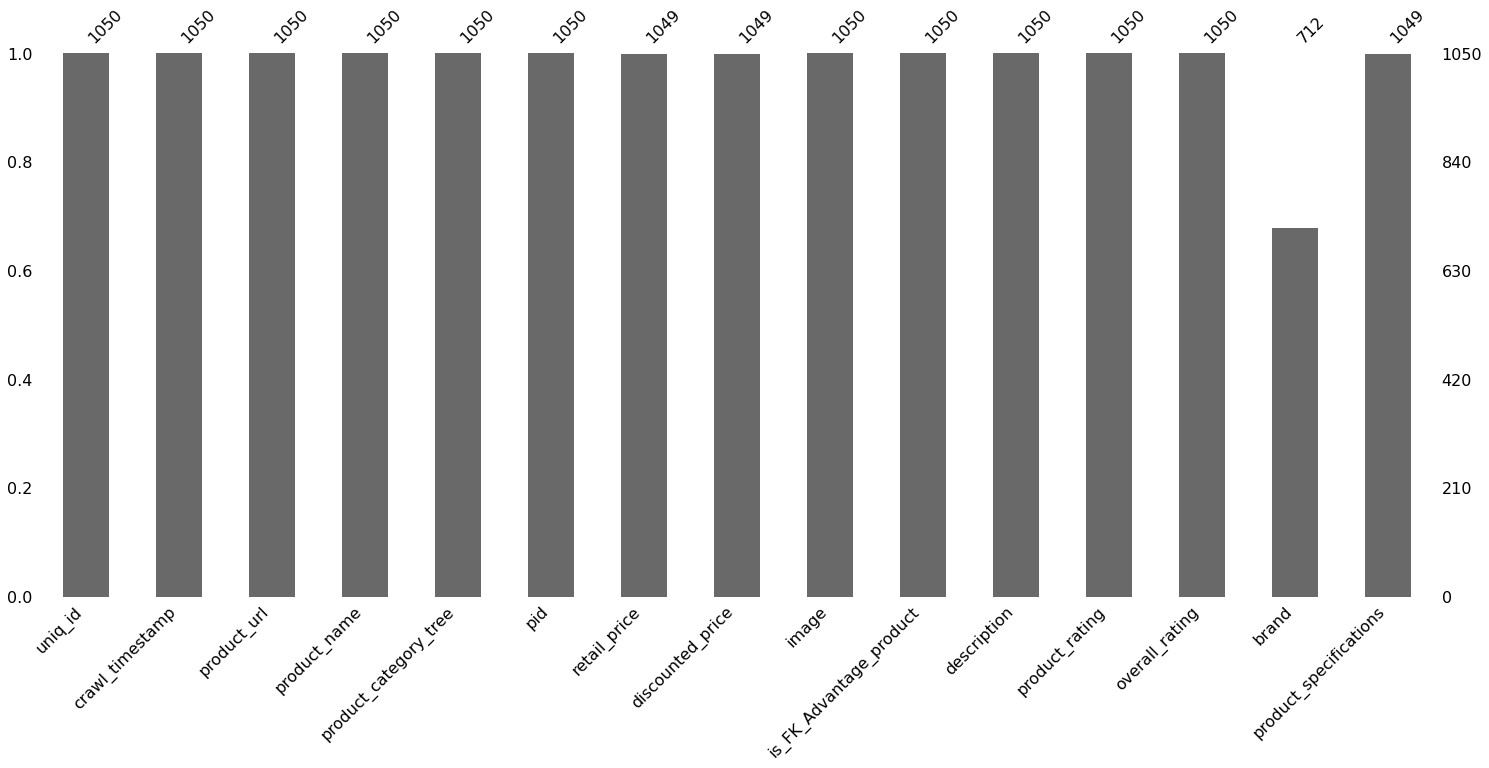

In [263]:
missingno.bar(data)


## Brand

In [264]:
brand_unique = data['brand'].nunique()
print(f'{brand_unique} brands uniques')


490 brands uniques


## Ratings

In [265]:
subplots_2(data, 'product_rating', 'overall_rating')


## Price

In [266]:
fig = make_subplots(rows=1, cols=2, subplot_titles=(
    'Retail Price', 'Discount Price'))
fig.add_trace(go.Histogram(
    x=data['retail_price'], nbinsx=1000, name="Retail Price"), row=1, col=1)
fig.add_trace(go.Histogram(
    x=data['discounted_price'], nbinsx=1000, name="Discount Price"), row=1, col=2)

fig.show()


In [267]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=data['retail_price'], name="Retail price", nbinsx=1000))
fig.add_trace(go.Histogram(
    x=data['discounted_price'], name="Discount Price", nbinsx=1000))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()


In [268]:
data[data['retail_price'] > 100000]


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
9,710ed5f2393a4b9e8823aa0029f71f93,2015-12-04 07:25:36 +0000,http://www.flipkart.com/tag-heuer-cau1116-ba08...,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,"[""Watches >> Wrist Watches >> TAG Heuer Wrist ...",WATEA6UGFGKZKDJC,107750.0,107750.0,710ed5f2393a4b9e8823aa0029f71f93.jpg,False,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."
11,08452abdadb3db1e686b94a9c52fc7b6,2015-12-04 07:25:36 +0000,http://www.flipkart.com/cartier-w6701005-analo...,"Cartier W6701005 Analog Watch - For Boys, Men","[""Watches >> Wrist Watches >> Cartier Wrist Wa...",WATEAK8SE2RUK7GM,201000.0,201000.0,08452abdadb3db1e686b94a9c52fc7b6.jpg,False,"Cartier W6701005 Analog Watch - For Boys, Men...",No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."


# Préparation de la data
## Colonnes inutiles

In [269]:
data_txt = data[['product_name', 'product_category_tree',
                 'description', 'product_specifications']]
data_txt


,product_name,product_category_tree,description,product_specifications
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,"{""product_specification""=>[{""key""=>""Material"",..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...,"{""product_specification""=>[{""key""=>""Number of ..."
1046,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...,"{""product_specification""=>[{""key""=>""Number of ..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"{""product_specification""=>[{""key""=>""Number of ..."
1048,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"{""product_specification""=>[{""key""=>""Number of ..."


## Catégories

In [270]:
def split_categorie(x, num_categorie):
    # on split la colonne product_category_tree entre les ">>" et on retient la catégorie qui nous intéresse
    x = x.split(">>")[num_categorie]
    # pour la catégorie 0, on supprime les caractères parasites ([")
    x = x.replace('["', '')
    return x


data_txt['categorie'] = data_txt['product_category_tree'].apply(
    lambda x: split_categorie(x, 0))
data_txt['sous_categorie'] = data_txt['product_category_tree'].apply(
    lambda x: split_categorie(x, 1))
data_txt


,product_name,product_category_tree,description,product_specifications,categorie,sous_categorie
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen
...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts
1046,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts
1048,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts


### Répartition


In [271]:
subplots_2(data_txt, 'categorie', 'sous_categorie', 2000)


On voit qu'il y a 7 catégories qui sont très bien équilibrés (150 produits chacun)

## Comptage des mots

In [272]:
# On clean la description en supprimant les stopwords, les majuscules, la ponctuation etc. etc.
# En faisant cela, on prépare notre variable pour le bag of words
data_txt['description_clean'] = data_txt['description'].apply(
    lambda x: transform_word(x, "classique"))
data_txt['description_clean_lem'] = data_txt['description'].apply(
    lambda x: transform_word(x, "lem"))
data_txt['description_clean_dl'] = data_txt['description'].apply(
    lambda x: transform_word(x, "dl"))

data_txt['description_len'] = compte_nombre_mots_colonne(
    data_txt, 'description_clean')


In [273]:
data_txt


,product_name,product_category_tree,description,product_specifications,categorie,sous_categorie,description_clean,description_clean_lem,description_clean_dl,description_len
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,156
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,63
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,158
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...,114
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...,156
...,...,...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,234
1046,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,wallmantra large vinyl sticker sticker pack pr...,wallmantra large vinyl sticker sticker pack pr...,wallmantra large vinyl sticker sticker ( pack ...,164
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,buy uberlyfe extra large pigmented polyvinyl f...,buy uberlyfe extra large pigmented polyvinyl f...,buy uberlyfe extra large pigmented polyvinyl f...,31
1048,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,buy wallmantra medium vinyl sticker sticker rs...,buy wallmantra medium vinyl sticker sticker rs...,buy wallmantra medium vinyl sticker sticker fo...,25


# Bag of words
## General

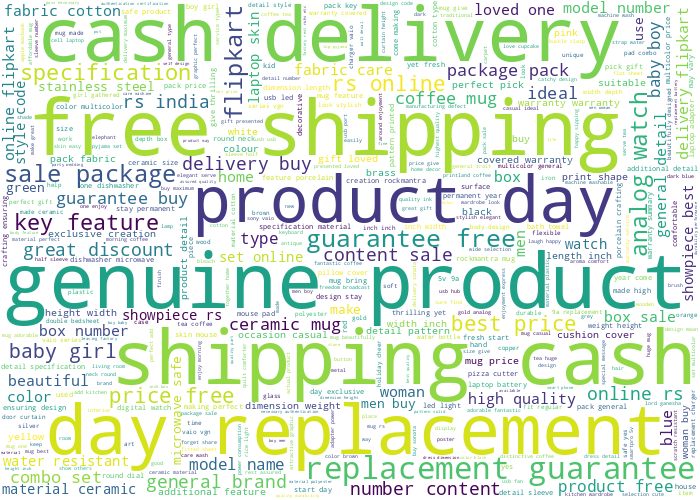

In [274]:
from wordcloud import WordCloud

# plt.figure(figsize=(15,15))
long_string = ",".join(list(data_txt['description_clean_lem'].values))
wordcloud = WordCloud(background_color="white", max_words=5000,
                      contour_width=5, contour_color='steelblue', width=700, height=500)
# Generate a word cloud
wc = wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


## Categorie

Bag of word pour Home Furnishing 


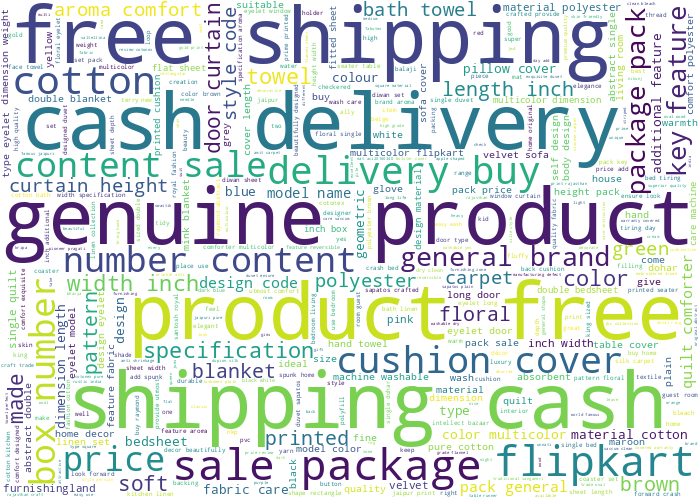

Bag of word pour Baby Care 


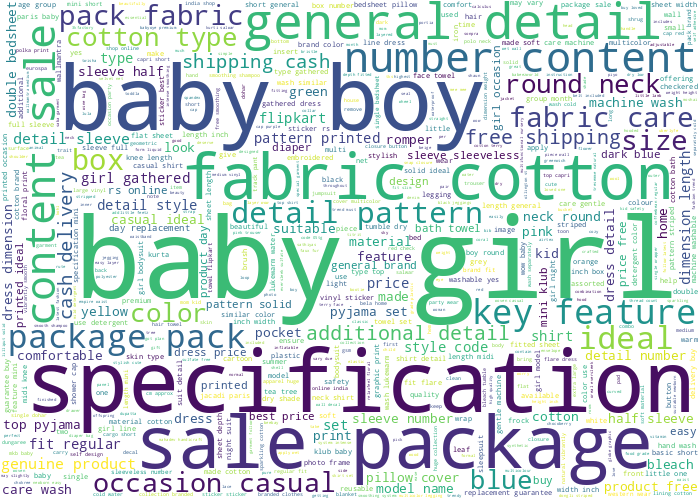

Bag of word pour Watches 


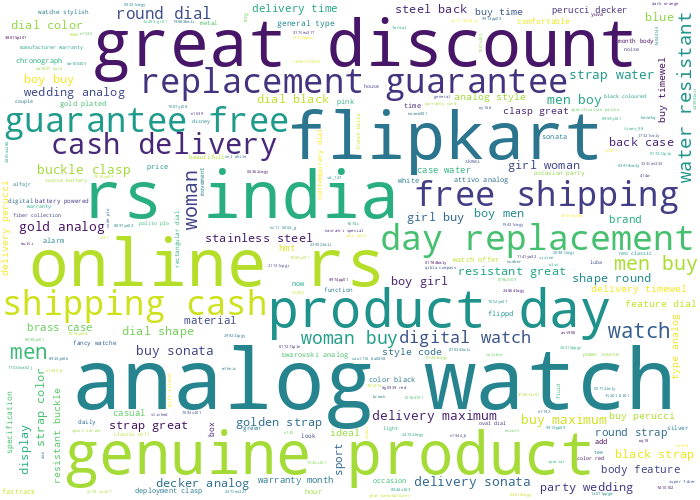

Bag of word pour Home Decor & Festive Needs 


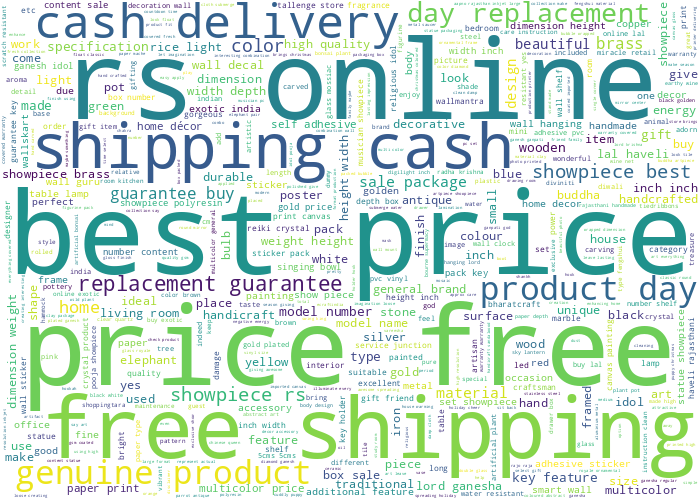

Bag of word pour Kitchen & Dining 


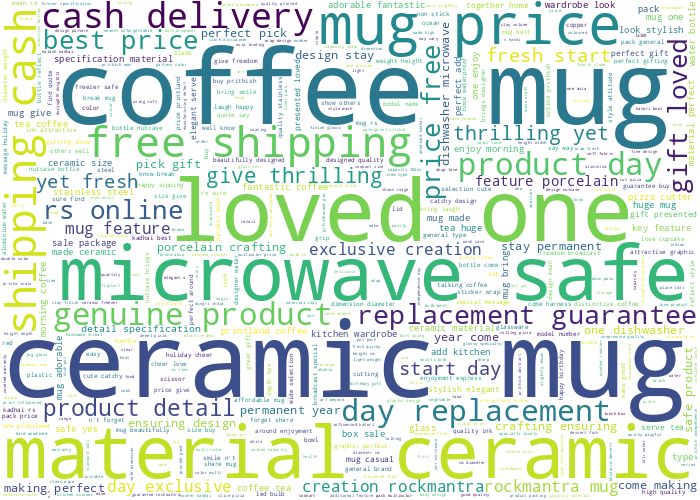

Bag of word pour Beauty and Personal Care 


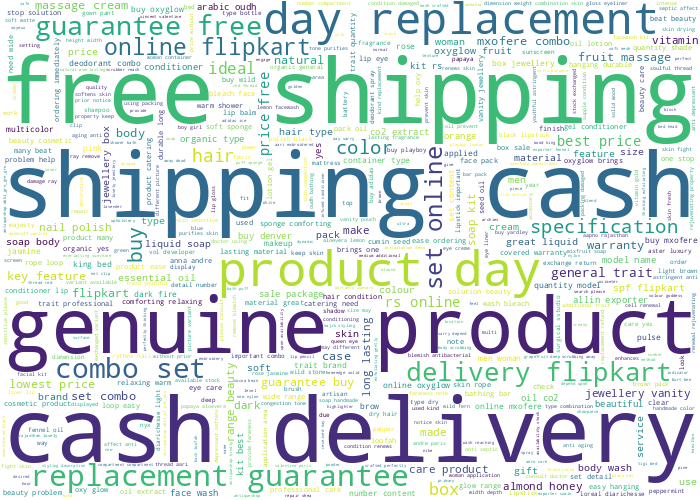

Bag of word pour Computers 


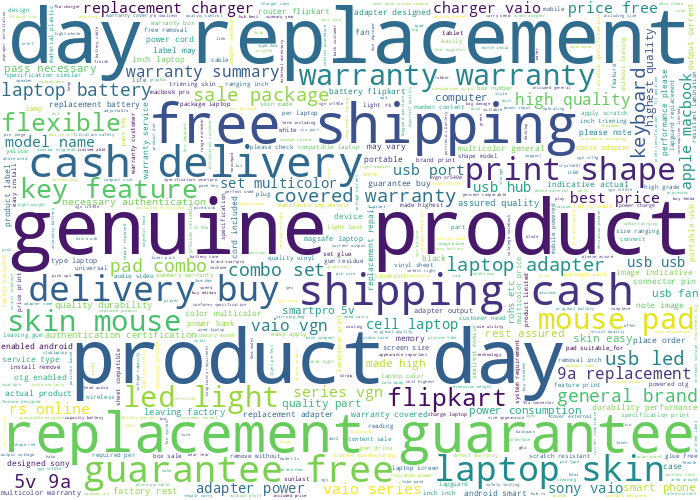

In [275]:
from IPython.display import display


def bag_of_word(data, categorie):
    # On filtre sur la catégorie
    data = data[data['categorie'] == categorie]

    long_string = ",".join(list(data['description_clean_lem'].values))
    wordcloud = WordCloud(background_color="white", max_words=5000,
                          contour_width=5, contour_color='steelblue', width=700, height=500)
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    print(f'Bag of word pour {categorie}')
    display(wordcloud.to_image())


for categorie in data_txt['categorie'].unique():
    bag_of_word(data_txt, categorie)


# Test

In [276]:
cv, ctf = creation_bag_of_words(data_txt, 'description_clean_lem')


## CountVectizer

In [277]:
categorie_list, y_cat_num = preparation_variable_clustering(
    data_txt, 'categorie')


ARI, X_tsne, labels = ARI_fct(cv, categorie_list, y_cat_num)


categories : [' Computers  : 0', ' Watches  : 1', ' Kitchen & Dining  : 2', ' Beauty and Personal Care  : 3', ' Home Decor & Festive Needs  : 4', ' Home Furnishing  : 5', ' Baby Care  : 6']
ARI :  0.3842 time :  7.0


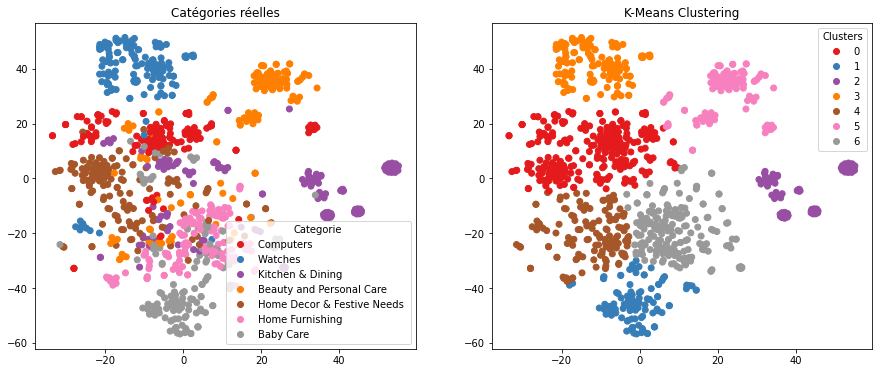

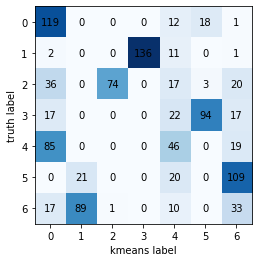

ARI :  0.3842


In [278]:
TSNE_visu_fct(X_tsne, categorie_list, y_cat_num, labels, ARI)


## Tf-idf

In [279]:
ARI, X_tsne, labels = ARI_fct(ctf, categorie_list, y_cat_num)


ARI :  0.4282 time :  6.0


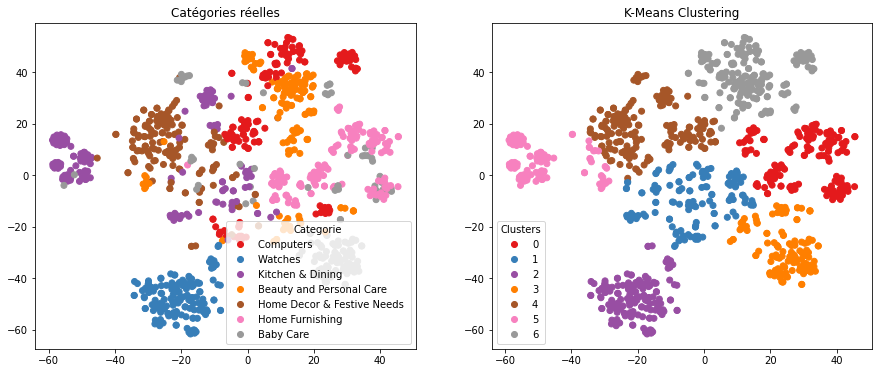

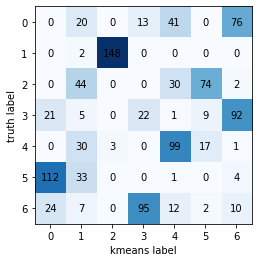

ARI :  0.4282


In [280]:
TSNE_visu_fct(X_tsne, categorie_list, y_cat_num, labels, ARI)


## BERT

In [281]:
model_type = 'bert-base-uncased'
sentences = data_txt['description_clean_dl'].to_list()

# model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
# bert_layer = hub.KerasLayer(model_url, trainable=True)


features_bert, last_hidden_states_tot = feature_BERT_fct(TFAutoModel.from_pretrained(model_type),
                                                         model_type,
                                                         sentences)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\Kevin/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-u

1/1 [==============================] - 0s 452ms/step
temps traitement :  54.0


In [282]:
ARI, X_tsne, labels = ARI_fct(features_bert, categorie_list, y_cat_num)


ARI :  0.3281 time :  6.0


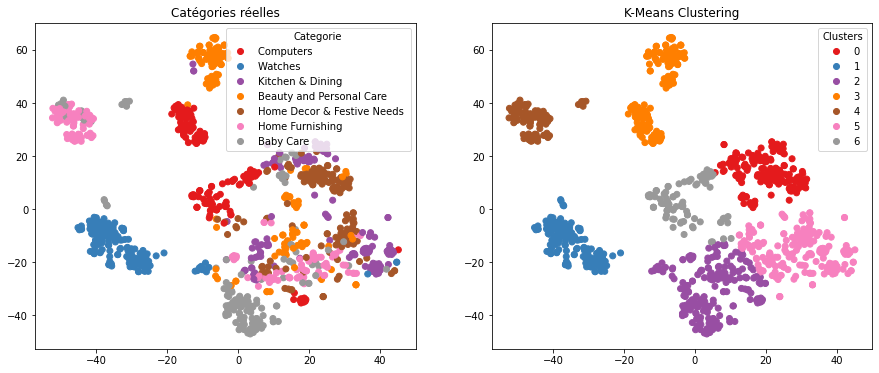

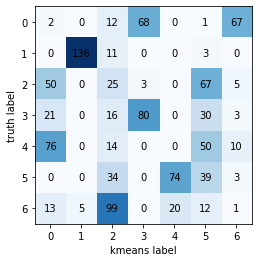

ARI :  0.3281


In [283]:
TSNE_visu_fct(X_tsne, categorie_list, y_cat_num, labels, ARI)
